# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Clément Vignac](https://people.epfl.ch/clement.vignac), [EPFL LTS4](https://lts4.epfl.ch) and
[Guillermo Ortiz Jiménez](https://gortizji.github.io), [EPFL LTS4](https://lts4.epfl.ch).

## Students

* Team: `<your team number>`
* Students: `<your name`> (for the indivudual submission) or `<the name of all students in the team>` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

*To be completed*

# Graph Signal Processing

In this part of the assignment we are going to familiarize ourselves with the main concepts in Graph Signal Processing. 

You can only use the following libraries for this part of the assignment.

In [1]:
from pygsp import graphs
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
%matplotlib inline

We start by importing the graph that will serve as support for our signals. In this exercise we will use a nearest-neighbor graph constructed from the Stanford Bunny point cloud included in the PyGSP library.

In [2]:
G = graphs.Bunny()
adjacency = np.asarray(G.W.todense())
n_nodes = adjacency.shape[0]

In [3]:
def plot_bunny(signal=None,title=''):
    fig = plt.gcf()
    ax = plt.gca()
    if not isinstance(ax, Axes3D):
        ax = plt.subplot(111, projection='3d')
    if signal is not None:
        signal = np.squeeze(signal)
    p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=signal, marker='o', s=5, cmap='RdBu_r')
    ax.view_init(elev=-90,azim=90)
    ax.dist = 7
    ax.set_axis_off()
    ax.set_title(title)
    if signal is not None:
        fig.colorbar(p)

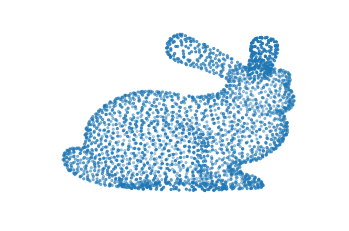

In [4]:
plt.subplot(111,projection='3d')
plot_bunny()

## Exercise 1

Let us start by constructing the combinatorial and normalized graph laplacians from an adjacency matrix.

In [5]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """Return the combinatorial or the symmetric normalized Laplacian."""
    D = np.diag(np.sum(adjacency, 1)) # Degree matrix
    combinatorial = D - adjacency
    if normalize:
        D_norm = np.diag(np.sum(adjacency, 1)**(-1/2)) 
        return D_norm @ combinatorial @ D_norm
    else:
        return combinatorial
    return D - adjacency

In [6]:
laplacian_comb = compute_laplacian(adjacency, False)
laplacian_norm = compute_laplacian(adjacency, True)

## Exercise 2

Find the spectral decomposition of the two laplacians. Make sure that the eigenvalues and eigenvectors are in increasing order $\lambda_0\leq \lambda_1\leq \dots \leq \lambda_n$.


In [7]:
def spectral_decomposition(laplacian: np.ndarray):
    """Return the eigenvalues and eigenvectors of the Laplacian."""
    return np.linalg.eigh(laplacian)

In [8]:
e_comb, U_comb = spectral_decomposition(laplacian_comb)
e_norm, U_norm = spectral_decomposition(laplacian_norm)

Plot the eigenvalues

Text(0.5, 1.0, 'Eigenvalues $L_{norm}$')

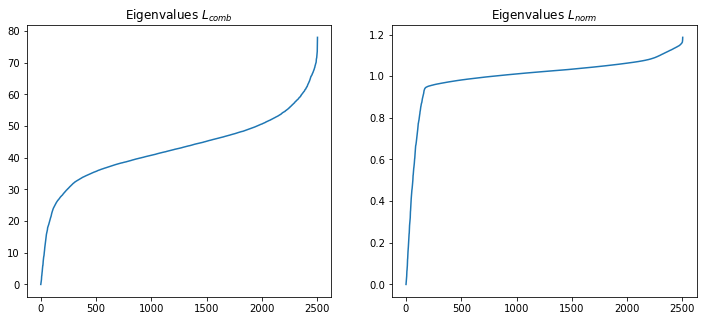

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(121,)
plt.plot(e_comb)
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(e_norm)
plt.title('Eigenvalues $L_{norm}$')

What do you observe? Can you say what is the relationship between the two plots?

Let us focus now on the normalized laplacian.

In [10]:
laplacian = laplacian_norm
U = U_norm
e = e_norm

To make things more clear we will plot some of its eigenvectors (0, 1, 3, 10, 100) as signals on the bunny graph.

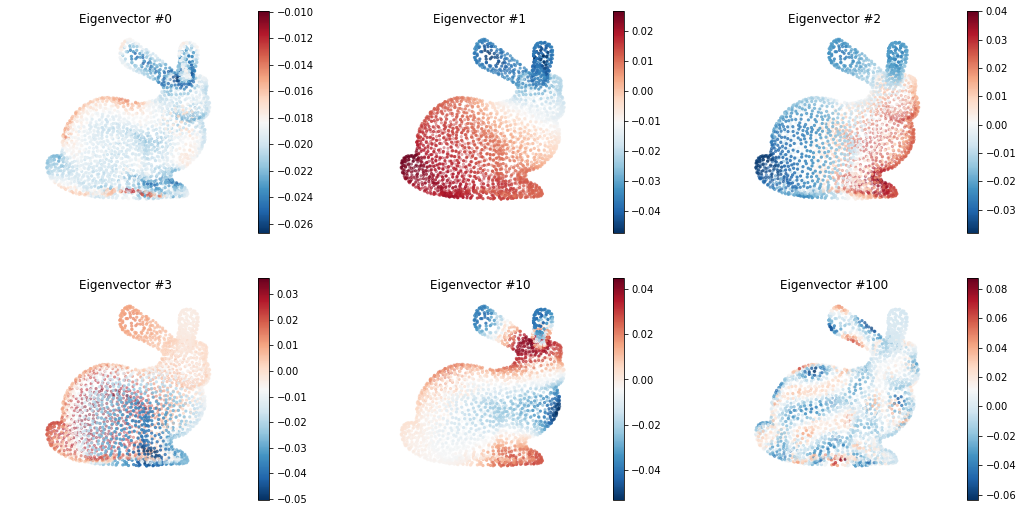

In [11]:
plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(signal=U[:,0], title='Eigenvector #0')
plt.subplot(232, projection='3d')
plot_bunny(signal=U[:,1], title='Eigenvector #1')
plt.subplot(233, projection='3d')
plot_bunny(signal=U[:,2], title='Eigenvector #2')

plt.subplot(234, projection='3d')
plot_bunny(signal=U[:,3], title='Eigenvector #3')
plt.subplot(235, projection='3d')
plot_bunny(signal=U[:,10], title='Eigenvector #10')
plt.subplot(236, projection='3d')
plot_bunny(signal=U[:,100], title='Eigenvector #100')

What can you say in terms of the variations/smoothness of these signals.

If we repeat this experiment with the combinatorial laplacian, can we expect the same behaviour? Explain.

## Exercise 3

Create a function to compute the Graph Fourier Transform and its inverse of a graph signal. **Note**: You can assume that you have internal access to the eigendecomposition (`U` and `e`) of the laplacian.

In [12]:
def GFT(signal: np.ndarray):
    return U.T @ signal

def iGFT(fourier_coefficients: np.ndarray):
    return U @ fourier_coefficients

Now, let's create an all-pass graph signal

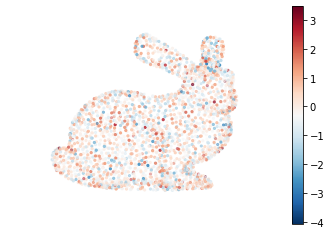

In [13]:
signal = iGFT(np.ones([n_nodes, 1]))
plot_bunny(signal)

and plot its graph spectrum

<StemContainer object of 3 artists>

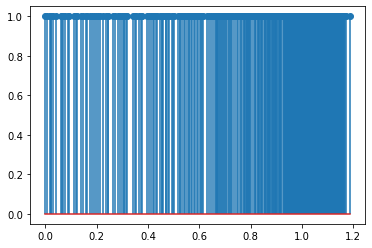

In [14]:
plt.stem(e, GFT(signal), use_line_collection=True)

We will filter this signal using spectral templates. Let us start by creating three templates

In [15]:
template_lp = np.ones(signal.shape)
template_bp = np.ones(signal.shape)
template_hp = np.ones(signal.shape)

template_lp[e >= 0.1] = 0 # Low-pass filter with cut-off at lambda=0.1
template_bp[e < 0.1] = 0 # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
template_bp[e > 0.5] = 0
template_hp[e <= 1] = 0 # High-pass filter with cut-off at lambda=1

Create a function to filter a signal given a specific spectral template

In [16]:
def template_graph_filter(signal: np.ndarray, template: np.ndarray):
    """Return a filtered signal."""
    signal_gft = GFT(signal)
    filter_gft = signal_gft * template
    return iGFT(filter_gft)

Let us visualize the results

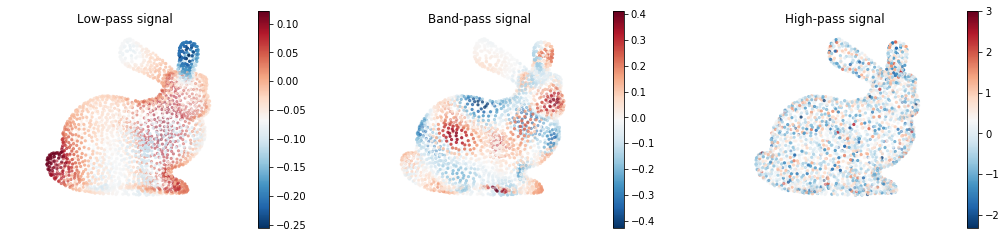

In [17]:
signal_lp = template_graph_filter(signal,template_lp)
signal_bp = template_graph_filter(signal,template_bp)
signal_hp = template_graph_filter(signal,template_hp)

plt.figure(figsize=(18, 4))
plt.subplot(131, projection='3d')
plot_bunny(signal=signal_lp, title='Low-pass signal')
plt.subplot(132, projection='3d')
plot_bunny(signal=signal_bp, title='Band-pass signal')
plt.subplot(133, projection='3d')
plot_bunny(signal=signal_hp, title='High-pass signal')

What can you say in terms of the signal variations? How would you link to the observations you made before about the spectral decomposition of the laplacian?

## Exercise 4

We have seen how we can use the GFT to define different filters that enhance or reduce certain frequency bands. However, to do so, we require an explicit eigendecomposition of the graph laplacian, which has a cost $O(n^3)$. For very large graphs this is very intense computationally. We will now see how we can obtain similar results by filtering the signals directly without resorting to an eigendecomposition.

The key idea is to use a polynomial of the graph laplacian to define a graph filter, i.e., $g(L)x=\sum_{k=1}^K \alpha_k L^k x$, and use the fact that the powers of a diagonalizable matrix can be written in terms of powers of its eigenvalues. This is
$$
\begin{equation}
        L^k=(U\Lambda U^T)^k=U\Lambda^k U^T = U\begin{bmatrix}
        \lambda_0^k &\dots & 0\\
        \vdots & \ddots & \vdots\\
        0 & \dots & \lambda_N
        \end{bmatrix} U^T
    \end{equation}
$$

This means, that a polynomial of the graph laplacian acts independently on each eigenvalue of the graph, and has a frequency spectrum of
$$g(\lambda)=\sum_{k=1}^K \alpha_k \lambda^k$$
Hence,
$$g(L)x=\sum_{k=1}^K \alpha_k L^k x=\sum_{k=1}^K \alpha_k U\Lambda^k U^T x=U \left(\sum_{k=1}^K \alpha_k\Lambda^k \right)U^T x=\operatorname{iGFT}\left(g(\Lambda)\operatorname{GFT}(x)\right)$$


With these ingredients, we have reduced the design of graph filters in the vertex domain to a regression task that approximates a given spectral response by a polynomial. There are multiple ways to do this, but in this assignment we will implement a very simple strategy based on [least-squares regression](https://en.wikipedia.org/wiki/Polynomial_regression#Matrix_form_and_calculation_of_estimates).

Let us create a band-pass universal spectral template:

In [18]:
freq_grid = np.linspace(0,2, 200)

template_bp = np.ones(freq_grid.shape)
template_bp[freq_grid < 0.1] = 0
template_bp[freq_grid >= 0.5] = 0

Implement a function to find the coefficients of a polynomial that approximates a given spectral template. **Hint:** `np.vander` and `np.linalg.lstsq`

In [19]:
def fit_polynomial(freq_grid: np.ndarray, order: int, template: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    A = np.vander(freq_grid, order, increasing=True)
    coeff = np.linalg.lstsq(A, template, rcond=None)[0]
    return coeff

Implement a function to compute the frequency response of that filter

In [20]:
def fir_graph_filter_response(coeff: np.array, freq_grid: np.ndarray):
    """ Return an array of the same shape as freq_grid.
        response[i] is the spectral response at frequency freq_grid[i]. """
    response = np.zeros_like(freq_grid)
    for n, c in enumerate(coeff):
        response += c * (freq_grid**n)
    return response

Let us fit the band-pass template with several polynomials of different order

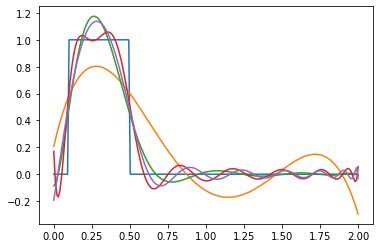

In [21]:
plt.plot(freq_grid, template_bp)
for order in [5, 10, 20, 30]:    
    coeff_bp = fit_polynomial(freq_grid, order, template_bp)
    plt.plot(freq_grid, fir_graph_filter_response(coeff_bp, freq_grid))

Based on the previous plot, choose a filter order that achieves (in your opinion) a good tradeoff in terms of computational complexity and response accuracy.

In [22]:
order = 10
coeff_bp = fit_polynomial(freq_grid, order, template_bp)

So far, we have only defined a way to compute the coefficients of our laplacian polynomial. Let us now compute our graph filter.

In [23]:
def fir_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    power = np.eye(laplacian.shape[0])
    filt = coeff[0] * power
    for n, c in enumerate(coeff[1:]):
        power = laplacian @ power
        filt += c * power
    return filt

In [24]:
g_bp = fir_graph_filter(coeff_bp, laplacian)

Filter the previous all-pass signal with this filter

In [25]:
signal_bp_fir = g_bp @ signal

Let us compare with the previous version

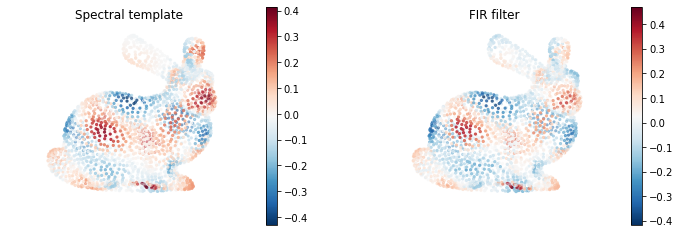

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(121, projection='3d')
plot_bunny(signal_bp, title='Spectral template')
plt.subplot(122, projection='3d')
plot_bunny(signal_bp_fir, title='FIR filter')

To better compare these signals, let us plot their spectrums

<StemContainer object of 3 artists>

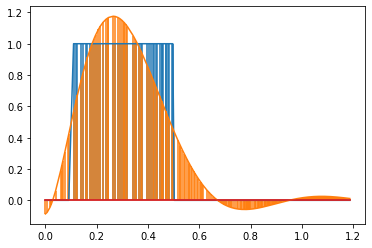

In [27]:
plt.stem(e, GFT(signal_bp), use_line_collection=True, linefmt='C0', markerfmt='C0')
plt.stem(e, GFT(signal_bp_fir), use_line_collection=True, linefmt='C1', markerfmt='C1')

# Machine learning on Graphs

So far, we have only played with toy examples. Let us see the use of these tools in practice! In particular, let us see how we can use some graph filters to construct features to feed a classifier. For this part of the assignment we will import some extra packages.

In [28]:
import networkx as nx

import time
import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl import DGLGraph
from dgl.data.citation_graph import load_cora
from sklearn.linear_model import LogisticRegression

np.random.seed(0)
torch.manual_seed(1)

We will use the CORA dataset and the citation graph that we created in Assignment 1. However, to simplify the next tasks we will directly use the preprocessed version of this dataset contained within the Deep Graph Library.

In this assignment, we will interpret CORA's features as multidimensional graph signals living on the citation graph. Our task is to design a classifier that using these features and the geometry of the graph can identify the type of paper each node represents.

The goal of this exercise is to do semi-supervised learning on graphs. We assume that we know to which scientific field belongs a small subset of the papers (the ones contained in train_mask). The goal is to predict to which field belong the other papers, using both the citation graph and the bag-of-word representation of each paper.

In [29]:
cora = load_cora()

features = torch.FloatTensor(cora.features)    # Feature vector for each paper
labels = torch.LongTensor(cora.labels)         # The field to which each paper belongs

train_mask = torch.BoolTensor(cora.train_mask) 
val_mask = torch.BoolTensor(cora.val_mask)
test_mask = torch.BoolTensor(cora.test_mask)

in_feats = features.shape[1]
n_classes = cora.num_labels
n_edges = cora.graph.number_of_edges()

graph = cora.graph
adjacency = np.asarray(nx.to_numpy_matrix(graph))

For this exercise we will use the combinatorial laplacian

In [30]:
laplacian = compute_laplacian(adjacency, normalize=False)
U, e = spectral_decomposition(laplacian)
e_max = np.max(e)
freq_grid = np.linspace(0, e_max)

## Exercise 5

### Logistic regression

The simplest method is to ignore the citation graph and try to classify the papers using only the features. In this case, the problem is viewed as a standard classification task. Use scikit learn to run logistic regression on this task.

In [31]:
train_features = features[train_mask]
train_labels = labels[train_mask]
val_features = features[val_mask]
val_labels = labels[val_mask]
test_features = features[test_mask]
test_labels = labels[test_mask]

In [32]:
log_reg = LogisticRegression(penalty='l2', multi_class="auto", solver="liblinear", C=1e4, fit_intercept=False, max_iter=1000)
log_reg.fit(train_features, train_labels)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
train_acc = log_reg.score(train_features, train_labels)
val_acc = log_reg.score(val_features, val_labels)
test_acc = log_reg.score(test_features, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.5967 | Test accuracy 0.6050


### Handcrafted graph filters

Now, we will try to take into account the graph structure using graph signal processing. For this purpose, we will design a handcrafted filter that will be used to denoise the signal, before feeding it to a logistic regression.

What hypothesis can you make on the spectral properties of the denoised signal? Based on what you learned in class, your past experience, and your intuition, design a graph spectral template that you believe could enhance important features of the graph. 

**Note 1:** You just need to design one graph filter that we will apply to all features. Don't design a different filter for each feature. 

**Note 2:** Finding the right filter can be very challenging, don't worry if you can't find it. Just make sure you experiment with a few configurations and parameters.

In [34]:
filter_template = np.ones(freq_grid.shape)

filter_template[freq_grid >= 0.3] = 0 # Low-pass filter with cut-off at lambda=0.1

Choose a filter order to approximate your filter using laplacian polynomials.

In [35]:
order = 5

coeff = fit_polynomial(freq_grid, order, filter_template)
graph_filter = fir_graph_filter(coeff, laplacian)

Let's plot the frequency response of your spectral template and the polynomial approximation

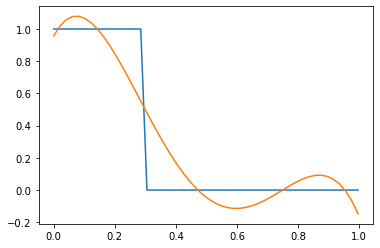

In [36]:
plt.plot(freq_grid, filter_template)
plt.plot(freq_grid, fir_graph_filter_response(coeff, freq_grid))

Now, let's create the new features

In [37]:
filtered_features = graph_filter @ features.numpy()

To train our classifier we will select a few nodes in our graph for training and fit a [logistic regression classifier](https://en.wikipedia.org/wiki/Logistic_regression) on them. To avoid overfitting to the test set when we do hyperparameter tuning, we will also select a validation set. And finally, we will test our classifier on the rest of the nodes.

In [38]:
train_features = filtered_features[train_mask,:]
train_labels = labels[train_mask]

val_features = filtered_features[val_mask,:]
val_labels = labels[val_mask]

test_features = filtered_features[test_mask,:]
test_labels = labels[test_mask]

Train a logistic regression classifier. Remember to play with the regularization parameters to achieve a well performing model. **Hint:** Use `sklearn.linear_model.LogisticRegression`.

In [39]:
log_reg = LogisticRegression(penalty='l2', multi_class="auto", solver="liblinear", C=1e4, fit_intercept=False, max_iter=1000)
log_reg.fit(train_features, train_labels)

/Users/clementvignac/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=10000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Let's evaluate your model...

In [40]:
train_acc = log_reg.score(train_features, train_labels)
val_acc = log_reg.score(val_features, val_labels)
test_acc = log_reg.score(test_features, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.9714 | Validation accuracy 0.4133 | Test accuracy 0.3100


## Exercise 6

By now, you will probably have seen that it is challenging to find the right combination of spectral response, filter parameters and regularization method. And in most cases, this is a painstaking job. Wouldn't it be great to automate these tasks?

Fortunately, this is possible if we use the right tools! Specifically, we will see that Graph Convolutional Networks are a great framework to automatize the feature extraction method, by simply using gradient descent.'

In this exercise, we will follow the same classification pipeline as in Exercise 5, but now, instead of hand-crafting our filter we will let `PyTorch` find the coefficients using gradient descent.

In this section, most of the code is already written. Try to understand it and to play with some parameters. It may be useful is you want to solve learning task in your project.

We start by constructing a `LaplacianPolynomial` model in `DGL`. It computes the function: $f(X) = \sum_{i=1}^{k} \alpha_i L^i X \theta$ where the trainable parameters are the coefficients $\alpha_i$ and the matrix $\theta$. This function can be interpreted as a filtering of $X$ by $\sum_{i=1}^{k} \alpha_i L^i$ followed by a linear layer.

In [41]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)


    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k):
            graph.ndata['h'] = feat
            # Update_all computes efficiently A @ feat
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            # LX = DX - AX
            feat = graph.in_degrees().float()[:, None] * feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

Once we have are model ready we just need to create a function that performs one step of our training loop, and another one that evaluates our model

In [42]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()    # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss


def evaluate(model, g, features, labels, mask):
    model.eval()   # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask] # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Choose the training parameters...

In [43]:
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 1000
p_dropout = 0.8

and let's train the classifier end to end. You should be able to obtain a test accuracy of more than 65%.

In [44]:
graph = DGLGraph(cora.graph)

model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

/Users/clementvignac/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/clementvignac/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 1.9459 | Val Accuracy 0.1600
Epoch 00001 | Time(s) nan | Train Loss 3.8731 | Val Accuracy 0.1833
Epoch 00002 | Time(s) nan | Train Loss 2.0940 | Val Accuracy 0.1767
Epoch 00003 | Time(s) 0.0175 | Train Loss 2.8990 | Val Accuracy 0.1967
Epoch 00004 | Time(s) 0.0182 | Train Loss 3.8503 | Val Accuracy 0.1867
Epoch 00005 | Time(s) 0.0181 | Train Loss 2.1611 | Val Accuracy 0.2000
Epoch 00006 | Time(s) 0.0183 | Train Loss 2.5059 | Val Accuracy 0.2000
Epoch 00007 | Time(s) 0.0184 | Train Loss 3.3099 | Val Accuracy 0.1900
Epoch 00008 | Time(s) 0.0184 | Train Loss 3.2475 | Val Accuracy 0.3533
Epoch 00009 | Time(s) 0.0184 | Train Loss 1.9366 | Val Accuracy 0.1667
Epoch 00010 | Time(s) 0.0184 | Train Loss 2.9027 | Val Accuracy 0.1700
Epoch 00011 | Time(s) 0.0184 | Train Loss 2.9171 | Val Accuracy 0.1733
Epoch 00012 | Time(s) 0.0185 | Train Loss 2.1271 | Val Accuracy 0.2800
Epoch 00013 | Time(s) 0.0184 | Train Loss 1.9733 | Val Accuracy 0.2567
Epoch 00014 | T

Epoch 00118 | Time(s) 0.0190 | Train Loss 0.1621 | Val Accuracy 0.7500
Epoch 00119 | Time(s) 0.0190 | Train Loss 0.4126 | Val Accuracy 0.7667
Epoch 00120 | Time(s) 0.0190 | Train Loss 0.1707 | Val Accuracy 0.7700
Epoch 00121 | Time(s) 0.0190 | Train Loss 0.2023 | Val Accuracy 0.7667
Epoch 00122 | Time(s) 0.0190 | Train Loss 0.1442 | Val Accuracy 0.7500
Epoch 00123 | Time(s) 0.0190 | Train Loss 0.1383 | Val Accuracy 0.7467
Epoch 00124 | Time(s) 0.0190 | Train Loss 0.1873 | Val Accuracy 0.7433
Epoch 00125 | Time(s) 0.0190 | Train Loss 0.1558 | Val Accuracy 0.7500
Epoch 00126 | Time(s) 0.0190 | Train Loss 0.1033 | Val Accuracy 0.7467
Epoch 00127 | Time(s) 0.0190 | Train Loss 0.0868 | Val Accuracy 0.7433
Epoch 00128 | Time(s) 0.0190 | Train Loss 0.1334 | Val Accuracy 0.7400
Epoch 00129 | Time(s) 0.0190 | Train Loss 0.3820 | Val Accuracy 0.7567
Epoch 00130 | Time(s) 0.0190 | Train Loss 0.2093 | Val Accuracy 0.7733
Epoch 00131 | Time(s) 0.0189 | Train Loss 0.1356 | Val Accuracy 0.7700
Epoch 

Epoch 00236 | Time(s) 0.0193 | Train Loss 0.1264 | Val Accuracy 0.7667
Epoch 00237 | Time(s) 0.0193 | Train Loss 0.0808 | Val Accuracy 0.7700
Epoch 00238 | Time(s) 0.0193 | Train Loss 0.0841 | Val Accuracy 0.7667
Epoch 00239 | Time(s) 0.0193 | Train Loss 0.1234 | Val Accuracy 0.7700
Epoch 00240 | Time(s) 0.0193 | Train Loss 0.0819 | Val Accuracy 0.7633
Epoch 00241 | Time(s) 0.0193 | Train Loss 0.1094 | Val Accuracy 0.7633
Epoch 00242 | Time(s) 0.0193 | Train Loss 0.1209 | Val Accuracy 0.7600
Epoch 00243 | Time(s) 0.0193 | Train Loss 0.0589 | Val Accuracy 0.7600
Epoch 00244 | Time(s) 0.0193 | Train Loss 0.0593 | Val Accuracy 0.7600
Epoch 00245 | Time(s) 0.0193 | Train Loss 0.1261 | Val Accuracy 0.7600
Epoch 00246 | Time(s) 0.0193 | Train Loss 0.1520 | Val Accuracy 0.7767
Epoch 00247 | Time(s) 0.0194 | Train Loss 0.0746 | Val Accuracy 0.7767
Epoch 00248 | Time(s) 0.0194 | Train Loss 0.0696 | Val Accuracy 0.7800
Epoch 00249 | Time(s) 0.0194 | Train Loss 0.0947 | Val Accuracy 0.7700
Epoch 

Epoch 00353 | Time(s) 0.0206 | Train Loss 0.2341 | Val Accuracy 0.7600
Epoch 00354 | Time(s) 0.0206 | Train Loss 0.1221 | Val Accuracy 0.7633
Epoch 00355 | Time(s) 0.0206 | Train Loss 0.1065 | Val Accuracy 0.7667
Epoch 00356 | Time(s) 0.0206 | Train Loss 0.0314 | Val Accuracy 0.7767
Epoch 00357 | Time(s) 0.0206 | Train Loss 0.1185 | Val Accuracy 0.7767
Epoch 00358 | Time(s) 0.0206 | Train Loss 0.0748 | Val Accuracy 0.7800
Epoch 00359 | Time(s) 0.0206 | Train Loss 0.0646 | Val Accuracy 0.7700
Epoch 00360 | Time(s) 0.0207 | Train Loss 0.0891 | Val Accuracy 0.7633
Epoch 00361 | Time(s) 0.0207 | Train Loss 0.0566 | Val Accuracy 0.7633
Epoch 00362 | Time(s) 0.0207 | Train Loss 0.0465 | Val Accuracy 0.7600
Epoch 00363 | Time(s) 0.0207 | Train Loss 0.1213 | Val Accuracy 0.7600
Epoch 00364 | Time(s) 0.0207 | Train Loss 0.0919 | Val Accuracy 0.7667
Epoch 00365 | Time(s) 0.0207 | Train Loss 0.1558 | Val Accuracy 0.7667
Epoch 00366 | Time(s) 0.0207 | Train Loss 0.0447 | Val Accuracy 0.7667
Epoch 

Epoch 00469 | Time(s) 0.0208 | Train Loss 0.1050 | Val Accuracy 0.7667
Epoch 00470 | Time(s) 0.0208 | Train Loss 0.0656 | Val Accuracy 0.7667
Epoch 00471 | Time(s) 0.0208 | Train Loss 0.0797 | Val Accuracy 0.7600
Epoch 00472 | Time(s) 0.0208 | Train Loss 0.2165 | Val Accuracy 0.7533
Epoch 00473 | Time(s) 0.0208 | Train Loss 0.1365 | Val Accuracy 0.7700
Epoch 00474 | Time(s) 0.0208 | Train Loss 0.0963 | Val Accuracy 0.7600
Epoch 00475 | Time(s) 0.0208 | Train Loss 0.1416 | Val Accuracy 0.7500
Epoch 00476 | Time(s) 0.0208 | Train Loss 0.2199 | Val Accuracy 0.7567
Epoch 00477 | Time(s) 0.0208 | Train Loss 0.3915 | Val Accuracy 0.7567
Epoch 00478 | Time(s) 0.0208 | Train Loss 0.0641 | Val Accuracy 0.7500
Epoch 00479 | Time(s) 0.0208 | Train Loss 0.0377 | Val Accuracy 0.7567
Epoch 00480 | Time(s) 0.0208 | Train Loss 0.2746 | Val Accuracy 0.7533
Epoch 00481 | Time(s) 0.0208 | Train Loss 0.1593 | Val Accuracy 0.7167
Epoch 00482 | Time(s) 0.0208 | Train Loss 0.5007 | Val Accuracy 0.7200
Epoch 

Epoch 00585 | Time(s) 0.0208 | Train Loss 0.2745 | Val Accuracy 0.7667
Epoch 00586 | Time(s) 0.0208 | Train Loss 0.4770 | Val Accuracy 0.7667
Epoch 00587 | Time(s) 0.0208 | Train Loss 0.2088 | Val Accuracy 0.7533
Epoch 00588 | Time(s) 0.0208 | Train Loss 0.1760 | Val Accuracy 0.7433
Epoch 00589 | Time(s) 0.0208 | Train Loss 0.3138 | Val Accuracy 0.7433
Epoch 00590 | Time(s) 0.0208 | Train Loss 0.3190 | Val Accuracy 0.7433
Epoch 00591 | Time(s) 0.0208 | Train Loss 1.1572 | Val Accuracy 0.7433
Epoch 00592 | Time(s) 0.0208 | Train Loss 0.6522 | Val Accuracy 0.7467
Epoch 00593 | Time(s) 0.0208 | Train Loss 0.3523 | Val Accuracy 0.7600
Epoch 00594 | Time(s) 0.0208 | Train Loss 0.5333 | Val Accuracy 0.7633
Epoch 00595 | Time(s) 0.0208 | Train Loss 0.4112 | Val Accuracy 0.7633
Epoch 00596 | Time(s) 0.0208 | Train Loss 0.2124 | Val Accuracy 0.7567
Epoch 00597 | Time(s) 0.0208 | Train Loss 0.1838 | Val Accuracy 0.7533
Epoch 00598 | Time(s) 0.0208 | Train Loss 0.8999 | Val Accuracy 0.7500
Epoch 

Epoch 00702 | Time(s) 0.0208 | Train Loss 0.2946 | Val Accuracy 0.7567
Epoch 00703 | Time(s) 0.0208 | Train Loss 0.0965 | Val Accuracy 0.7500
Epoch 00704 | Time(s) 0.0208 | Train Loss 0.0817 | Val Accuracy 0.7567
Epoch 00705 | Time(s) 0.0208 | Train Loss 0.1991 | Val Accuracy 0.7633
Epoch 00706 | Time(s) 0.0208 | Train Loss 0.2503 | Val Accuracy 0.7667
Epoch 00707 | Time(s) 0.0208 | Train Loss 0.2742 | Val Accuracy 0.7600
Epoch 00708 | Time(s) 0.0208 | Train Loss 0.1052 | Val Accuracy 0.7533
Epoch 00709 | Time(s) 0.0208 | Train Loss 0.1066 | Val Accuracy 0.7600
Epoch 00710 | Time(s) 0.0208 | Train Loss 0.0978 | Val Accuracy 0.7533
Epoch 00711 | Time(s) 0.0208 | Train Loss 0.2880 | Val Accuracy 0.7633
Epoch 00712 | Time(s) 0.0208 | Train Loss 0.1918 | Val Accuracy 0.7667
Epoch 00713 | Time(s) 0.0208 | Train Loss 0.4744 | Val Accuracy 0.7567
Epoch 00714 | Time(s) 0.0208 | Train Loss 0.9403 | Val Accuracy 0.7533
Epoch 00715 | Time(s) 0.0208 | Train Loss 1.0397 | Val Accuracy 0.7633
Epoch 

Epoch 00818 | Time(s) 0.0208 | Train Loss 0.1779 | Val Accuracy 0.7600
Epoch 00819 | Time(s) 0.0208 | Train Loss 0.2422 | Val Accuracy 0.7567
Epoch 00820 | Time(s) 0.0208 | Train Loss 0.1325 | Val Accuracy 0.7600
Epoch 00821 | Time(s) 0.0208 | Train Loss 0.1638 | Val Accuracy 0.7567
Epoch 00822 | Time(s) 0.0208 | Train Loss 0.1348 | Val Accuracy 0.7600
Epoch 00823 | Time(s) 0.0208 | Train Loss 0.0322 | Val Accuracy 0.7600
Epoch 00824 | Time(s) 0.0208 | Train Loss 0.3433 | Val Accuracy 0.7567
Epoch 00825 | Time(s) 0.0208 | Train Loss 0.4086 | Val Accuracy 0.7600
Epoch 00826 | Time(s) 0.0208 | Train Loss 0.1450 | Val Accuracy 0.7600
Epoch 00827 | Time(s) 0.0208 | Train Loss 0.0536 | Val Accuracy 0.7633
Epoch 00828 | Time(s) 0.0208 | Train Loss 0.2740 | Val Accuracy 0.7600
Epoch 00829 | Time(s) 0.0208 | Train Loss 0.1327 | Val Accuracy 0.7533
Epoch 00830 | Time(s) 0.0208 | Train Loss 0.1715 | Val Accuracy 0.7567
Epoch 00831 | Time(s) 0.0208 | Train Loss 0.1513 | Val Accuracy 0.7567
Epoch 

Epoch 00935 | Time(s) 0.0208 | Train Loss 2.6492 | Val Accuracy 0.7533
Epoch 00936 | Time(s) 0.0208 | Train Loss 0.3987 | Val Accuracy 0.7433
Epoch 00937 | Time(s) 0.0208 | Train Loss 0.6752 | Val Accuracy 0.7233
Epoch 00938 | Time(s) 0.0208 | Train Loss 4.6075 | Val Accuracy 0.7167
Epoch 00939 | Time(s) 0.0208 | Train Loss 1.7511 | Val Accuracy 0.7200
Epoch 00940 | Time(s) 0.0209 | Train Loss 1.0009 | Val Accuracy 0.7300
Epoch 00941 | Time(s) 0.0208 | Train Loss 1.0271 | Val Accuracy 0.7300
Epoch 00942 | Time(s) 0.0208 | Train Loss 0.5062 | Val Accuracy 0.7400
Epoch 00943 | Time(s) 0.0209 | Train Loss 0.2984 | Val Accuracy 0.7467
Epoch 00944 | Time(s) 0.0209 | Train Loss 0.6309 | Val Accuracy 0.7400
Epoch 00945 | Time(s) 0.0208 | Train Loss 2.4931 | Val Accuracy 0.7367
Epoch 00946 | Time(s) 0.0208 | Train Loss 1.0496 | Val Accuracy 0.7433
Epoch 00947 | Time(s) 0.0208 | Train Loss 0.5204 | Val Accuracy 0.7400
Epoch 00948 | Time(s) 0.0209 | Train Loss 0.1806 | Val Accuracy 0.7333
Epoch 

Trained this way our GCN based on polynomials of the laplacian is a black box. Fortunately, however, the only difference between this shallow model and our previous classifier is the way we chose the filter coefficients.

Let's see what the network learnt...

In [45]:
coeff_gcn = model.pol_weights.detach().numpy()
print(coeff_gcn)

[ 1.7719086e+01 -4.4402270e+00  1.8523736e-01  9.2400319e-04]


To interpret the model we can plot the frequency response of the learned filter

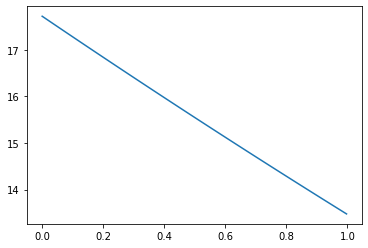

In [46]:
plt.plot(freq_grid, fir_graph_filter_response(coeff_gcn, freq_grid))

Based on your previous results, what type of graph filter would you say this is?

## Exercise 7

If everything is correct we should be able to use this filter to construct new hand-crafted filters and train a logistic regression model that achieves good accuracy on the training set. Let's do that!

Use the learned coefficients to train a new feature extractor

In [47]:
graph_gcn = fir_graph_filter(coeff_gcn, laplacian)

Extract the new features by filtering the data

In [48]:
features_gcn = graph_gcn @ features.numpy()

Train a logistic regression on this features

In [49]:
train_features_gcn = features_gcn[train_mask,:]
train_labels = labels[train_mask]
val_features_gcn = features_gcn[val_mask,:]
val_labels = labels[val_mask]
test_features_gcn = features_gcn[test_mask,:]
test_labels = labels[test_mask]

log_reg_gcn = LogisticRegression(penalty='l2', multi_class="auto", solver="liblinear", C=1e4, fit_intercept=False, max_iter=1000)
log_reg_gcn.fit(train_features_gcn, train_labels)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Finally, let's evaluate this model

In [50]:
train_acc = log_reg_gcn.score(train_features_gcn, train_labels)
val_acc = log_reg_gcn.score(val_features_gcn, val_labels)
test_acc = log_reg_gcn.score(test_features_gcn, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.7533 | Test accuracy 0.7520


The performance of this model may not be exactly the same as the one obtained with Pytorch. What are the differences in the training procedure that can explain this gap?